# Lab 1

## Question 1

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os 
import statsmodels.api as sm
import powerlaw
import scipy.stats as stats

### Dataset

Perform general statistical analyses on the datasets.  Are the results expected ?Perform some sanity checks on the data.  Is the dataset free of visible problems ?

In [4]:
def get_all_files(directory):
    files = [f for f in os.listdir(directory) 
             if os.path.isfile(os.path.join(directory, f))]
    return files

In [5]:
files = get_all_files(os.path.join('data', 'SG'))

dfs = []

for i, file in enumerate(files):
    df_small = pd.read_csv(os.path.join('data', 'SG', file), index_col = 0)
    dfs.append(df_small)
    if i == 1:
        break  # < ----------------- remove this line to read all files
df = pd.concat(dfs)
df['ets'] = pd.to_datetime(df['ets'], format='%Y%m%d:%H:%M:%S.%f')
df.head()

,ets,etype,eprice,eqty,eside,bp0,bq0,ap0,aq0
0,2017-01-17 09:01:00.270164,A,45610,1400,B,46010,1066,46085,1445
1,2017-01-17 09:01:00.312121,A,46485,700,S,46010,1066,46085,1445
2,2017-01-17 09:01:00.358162,A,46000,124,B,46010,1066,46085,1445
3,2017-01-17 09:01:00.359972,A,45950,182,B,46010,1066,46085,1445
4,2017-01-17 09:01:00.360001,A,45970,22,B,46010,1066,46085,1445


In [6]:
# file_path = "/Users/hugo/Downloads/Data 2/SG/SG_20170118.csv.gz"
file_path = os.path.join('data', 'SG', 'SG_20170118.csv.gz')

df = pd.read_csv(file_path, index_col=0, compression='gzip')

df['ets'] = pd.to_datetime(df['ets'], format='%Y%m%d:%H:%M:%S.%f')

df.head()


,ets,etype,eprice,eqty,eside,bp0,bq0,ap0,aq0
0,2017-01-18 09:01:00.026864,A,45650,16107,B,45945,450,46015,1407
1,2017-01-18 09:01:00.026919,A,46405,16107,S,45945,450,46015,1407
2,2017-01-18 09:01:00.104442,C,45895,200,B,45945,450,46015,1407
3,2017-01-18 09:01:00.105053,A,45875,200,B,45945,450,46015,1407
4,2017-01-18 09:01:00.105062,C,45905,200,B,45945,450,46015,1407


- A: add limit order
- T: Trade (takes the best price)
- M: Modification
- C: Cancel

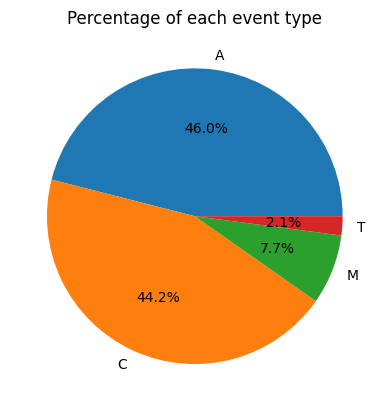

In [7]:
plt.title("Percentage of each event type")
plt.pie(df['etype'].value_counts() / len(df), labels=df['etype'].value_counts().index, autopct='%1.1f%%')
plt.show()

Only 2.1% of real match-making trades really taking place out of all of the placed orders !

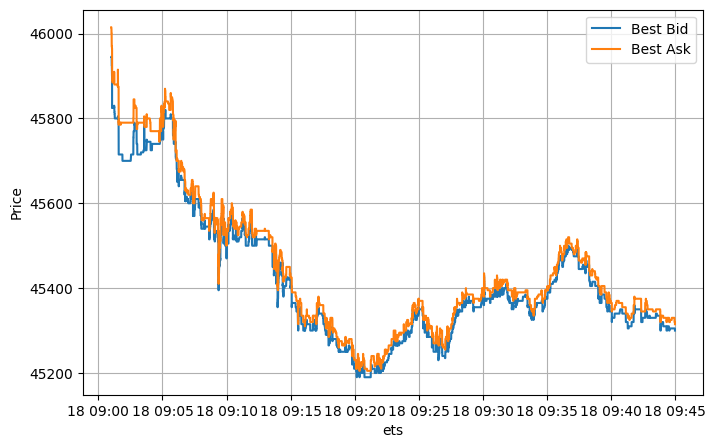

In [8]:
df_2 = df.copy()
df_2.set_index('ets', inplace=True)
df_2.sort_index(inplace=True, ascending=True)

start_date = '2017-01-18 09:01:00.270164'
end_date = '2017-01-18 09:45:00.00'

plt.figure(figsize=(8, 5))
sns.lineplot(data=df_2[start_date:end_date], x='ets', y='bp0', label="Best Bid")
sns.lineplot(data=df_2[start_date:end_date], x='ets', y='ap0', label="Best Ask")
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

#### Trade Volumes

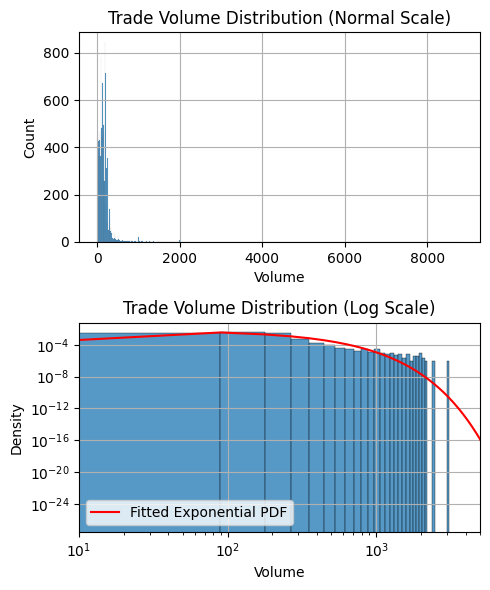

In [9]:
# Filter the DataFrame for trades
df_trades = df[df['etype'] == 'T'].copy()

# Fit an exponential distribution to the data
loc, scale = stats.expon.fit(df_trades['eqty'])

# Create a finer grid for plotting the fitted PDF
x_fit = np.linspace(0, np.max(df_trades['eqty']), 100)
y_fit = stats.expon.pdf(x_fit, loc=loc, scale=scale)


# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(5, 6))

# Normal scale plot
sns.histplot(df_trades, x='eqty', kde=False, ax=axes[0])
axes[0].set_title('Trade Volume Distribution (Normal Scale)')
axes[0].set_xlabel('Volume')
axes[0].grid()

# Logarithmic scale plot
sns.histplot(df_trades, x='eqty', 
             kde=False, stat='density', bins=100, ax=axes[1])
sns.lineplot(x=x_fit, y=y_fit, 
             color='red', ax=axes[1], label='Fitted Exponential PDF')
axes[1].set_xlim(1e1, 5e3)
axes[1].set_yscale('log')
axes[1].set_xscale('log')
axes[1].set_xlabel('Volume')
axes[1].set_ylabel('Density')
axes[1].set_title('Trade Volume Distribution (Log Scale)')
axes[1].grid()

plt.tight_layout()
plt.show()

From the graph above, we can appreciate that the trade volumes doesnt follow a exponential distribution. We can see that is has heavier tails than this distribution. This is in concordance with the course content.

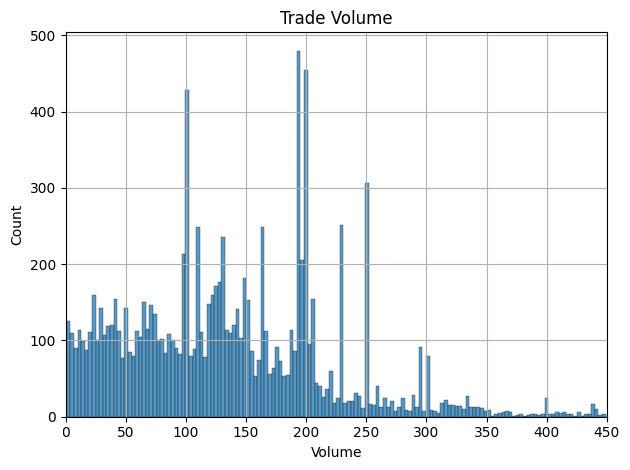

In [10]:
x_sup = 450

sns.histplot(df_trades.loc[df_trades['eqty'] < x_sup], 
             x='eqty', kde=False, bins=150)
plt.xlim(0, x_sup)
plt.title('Trade Volume')
plt.xlabel('Volume')
plt.ylabel('Count')
plt.tight_layout()
plt.grid()
plt.show()

We can appreciate from the previous graph, that some trade volumes are very high, specially for the amount of 100, 200, 250 and 300; compared to their neighbor values.

Calculating best minimal value for power law fit


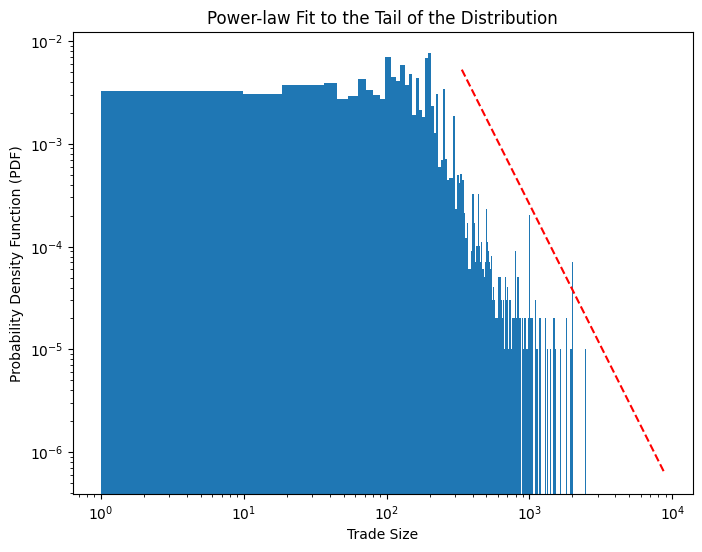

Power-law alpha: 2.7625888116205477
Power-law xmin: 336.0


In [11]:
# Use the powerlaw package to fit the data
fit = powerlaw.Fit(df_trades["eqty"])

plt.figure(figsize=(8, 6))

alpha = fit.power_law.alpha
xmin = fit.power_law.xmin
plt.hist(df_trades["eqty"], bins=1000, density=True)
fit.power_law.plot_pdf(color='r', linestyle='--')

plt.xlabel('Trade Size')
plt.ylabel('Probability Density Function (PDF)')
plt.title('Power-law Fit to the Tail of the Distribution')
plt.show()

# Print the estimated parameters
print(f"Power-law alpha: {alpha}")
print(f"Power-law xmin: {xmin}")

A power-law distribution follows the form:

\begin{equation}
    P(x) \propto x^{-\alpha}
\end{equation}

where:

- $\alpha$ is the scaling exponent, determining how quickly the probability decays.
- The $x_{min}$ is the lower bound, meaning the power-law behavior holds only for values greater than or equal to this threshold.

The alpha of the data is higher than 2 but lower than 3, which means that the data has a finite mean, but an infinite variance, which also means that the data has heavier tails than an exponential distribution.

#### Trade duration

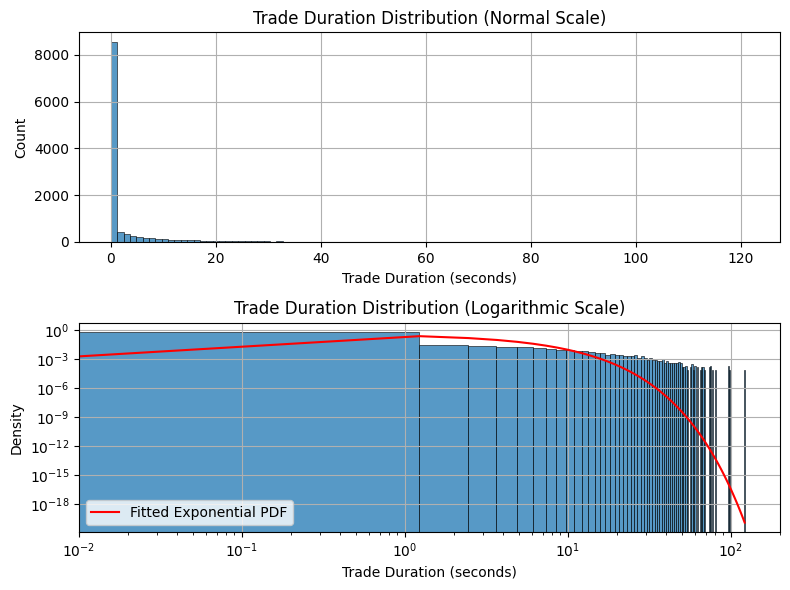

In [12]:
df_trades = df[df['etype'] == 'T'].copy()
df_trades['trade_duration'] = df_trades['ets'].diff().dt.total_seconds()
df_trades = df_trades.iloc[1:].dropna()

# Fit an exponential distribution to the data
loc, scale = stats.expon.fit(df_trades['trade_duration'])

# Create a finer grid for plotting the fitted PDF
x_fit = np.linspace(0, np.max(df_trades['trade_duration']), 100)
y_fit = stats.expon.pdf(x_fit, loc=loc, scale=scale)


fig, axes = plt.subplots(2, 1, figsize=(8, 6))

sns.histplot(df_trades, x='trade_duration', kde=False, bins=100, ax=axes[0])
axes[0].set_title('Trade Duration Distribution (Normal Scale)')
axes[0].set_xlabel('Trade Duration (seconds)')
axes[0].grid()

sns.histplot(df_trades, x='trade_duration', 
             kde=False, bins=100, 
             stat='density', ax=axes[1])
sns.lineplot(x=x_fit, y=y_fit, 
             color='red', ax=axes[1], label='Fitted Exponential PDF')
axes[1].set_yscale('log')
axes[1].set_xscale('log')
axes[1].set_xlim(1e-2, 2e2)
axes[1].set_ylabel('Density')
axes[1].set_xlabel('Trade Duration (seconds)')
axes[1].set_title('Trade Duration Distribution (Logarithmic Scale)')
axes[1].grid()

plt.tight_layout()
plt.show()

We can appreciate in the previous graph, that the data doesnt follow a exponential distribution. We can see that the data has heavier tails than this distribution. This is in concordance with the course content.

#### Trading activity and volatility

In [13]:
df_trades = df[df['etype'] == 'T'].copy()
df_trades = df_trades.sort_values('ets')
df_trades = df_trades.reset_index(drop=True)

df_trades['log_return'] = np.log(df_trades['eprice'] / df_trades['eprice'].shift(1))
df_trades['variance_log_returns'] = df_trades['log_return'].expanding().var(ddof=1)
df_trades = df_trades.dropna()
df_trades.head(1)

,ets,etype,eprice,eqty,eside,bp0,bq0,ap0,aq0,log_return,variance_log_returns
2,2017-01-18 09:01:01.818116,T,45945,15,B,45930,70,46000,1298,0.0,0.0


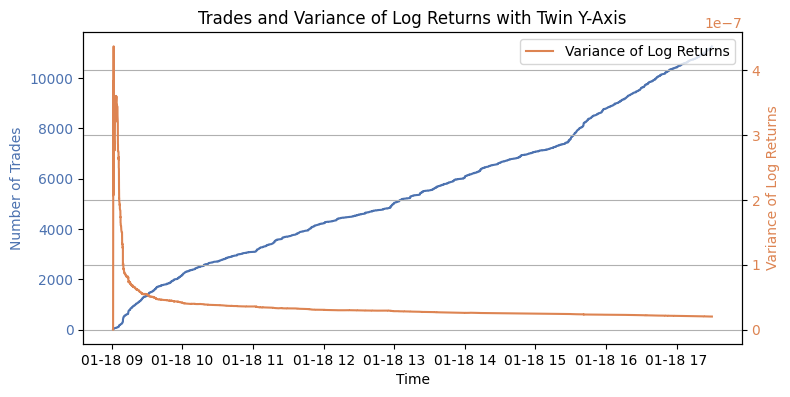

In [14]:
fig, ax1 = plt.subplots(figsize=(8, 4))
colors = sns.color_palette("deep")

ax1.plot(df_trades['ets'], np.arange(1, len(df_trades) + 1), 
         label='Number of Trades', color=colors[0])
ax1.set_xlabel('Time')
ax1.set_ylabel('Number of Trades', color=colors[0])
ax1.tick_params(axis='y', labelcolor=colors[0])

ax2 = ax1.twinx()
sns.lineplot(data=df_trades, x='ets', y='variance_log_returns', 
             label='Variance of Log Returns', ax=ax2, color=colors[1])
ax2.set_ylabel('Variance of Log Returns', color=colors[1])
ax2.tick_params(axis='y', labelcolor=colors[1])

fig.tight_layout()
plt.title('Trades and Variance of Log Returns with Twin Y-Axis')
plt.grid(True)
plt.show()

We can appreciate that the variance is reducing along time. 

---

**HUGO CHECK!!**


---

### Mid-Price and Weighted Mid-Price Visualization

The mid-price is defined as :

$$Mid\text{-}Price = \frac{a(t) + b(t)}{2}$$

The **weighted mid-price** is defined as:

$$W_{mid-price} = \frac{a(t)q^B(t) + b(t)q^A(t)}{q^B(t) + q^A(t)}$$

In [15]:
# bp0, bq0,	ap0, aq0
# best bid price, best bid quantity, best ask price, best ask quantity

df['mid_price'] = (df['bp0'] + df['ap0']) / 2

df['weighted_mid_price'] = ((df['bp0'] * df['aq0']) + (df['ap0'] * df['bq0'])) / (df['bq0'] + df['aq0'])

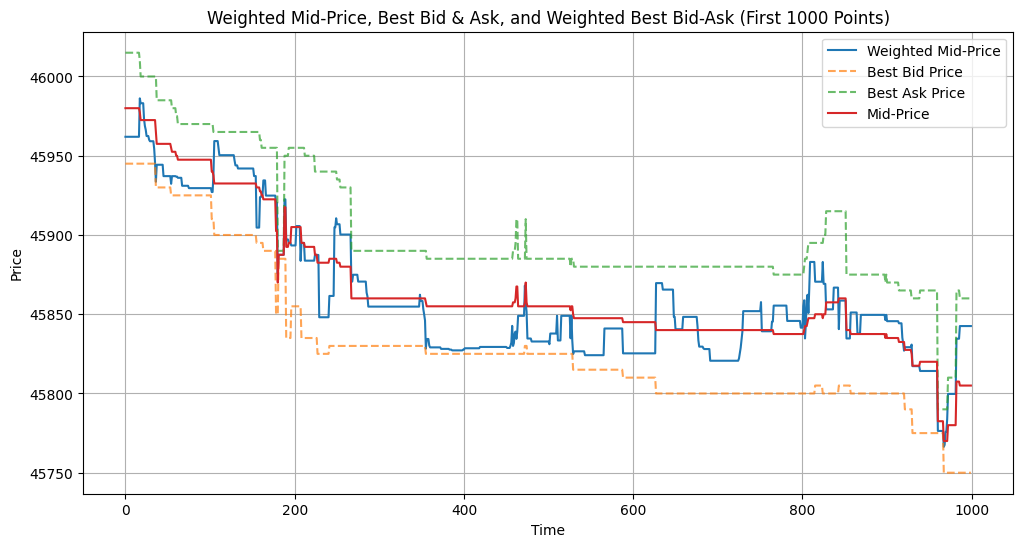

In [16]:
df_subset = df.iloc[:1000]

plt.figure(figsize=(12, 6))
df_subset['weighted_mid_price'].plot(label="Weighted Mid-Price", linestyle='-', linewidth=1.5)
df_subset['bp0'].plot(label="Best Bid Price", linestyle='--', alpha=0.7)
df_subset['ap0'].plot(label="Best Ask Price", linestyle='--', alpha=0.7)
df_subset['mid_price'].plot(label="Mid-Price", linestyle='-', linewidth=1.5)

plt.xlabel("Time")
plt.ylabel("Price")
plt.title("Weighted Mid-Price, Best Bid & Ask, and Weighted Best Bid-Ask (First 1000 Points)")
plt.legend()
plt.grid(True)
plt.show()

The graph doesnt show any issue about the calculation of the mid price and the weighted mid price. We can appreciate that the price of the stock is discrete along the time, where there are some specific moments where the bid and ask prices converges to the same value.

### Tick size

In [17]:
df['tick_size_bid'] = df['bp0'].diff().abs()
df['tick_size_ask'] = df['ap0'].diff().abs()

tick_sizes = pd.concat(
  [df['tick_size_bid'], df['tick_size_ask']]
  ).replace(0, np.nan).dropna()

measured_tick_size = tick_sizes.min()

print('The smallest tick size occuring on the dataset is in',
      f'line with the official tick size : {measured_tick_size}',
        'for stocks between 9.99 and 50 Euros as outlined in the course',
        sep='\n')

The smallest tick size occuring on the dataset is in
line with the official tick size : 5.0
for stocks between 9.99 and 50 Euros as outlined in the course


## Question II

### Spread

In [18]:
df['spread'] = df['ap0'] - df['bp0']

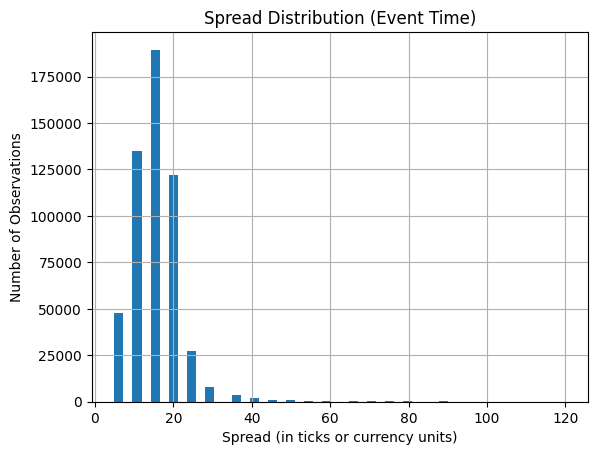

In [19]:
plt.figure()
df['spread'].hist(bins=50)
plt.title("Spread Distribution (Event Time)")
plt.xlabel("Spread (in ticks or currency units)")
plt.ylabel("Number of Observations")
plt.show()

In [20]:
spread_counts = df['spread'].value_counts().sort_index()
spread_freq = spread_counts / spread_counts.sum()
print(spread_freq.head(10))

spread
5     0.088564
10    0.249884
15    0.351210
20    0.226561
25    0.050520
30    0.015160
35    0.006527
40    0.003612
45    0.002043
50    0.001265
Name: count, dtype: float64


In [ ]:
df.index = pd.to_datetime(df.index) 
df['ts_next'] = df.index.to_series().shift(-1)  # Shift index to get next timestamp
df['delta'] = (df['ts_next'] - df.index.to_series()).dt.total_seconds()  # Compute time difference

# Drop last row where 'delta' is NaN (because there's no next timestamp)
df.dropna(subset=['delta'], inplace=True)


In [26]:
df.head(10)

,ets,etype,eprice,eqty,eside,bp0,bq0,ap0,aq0,mid_price,weighted_mid_price,tick_size_bid,tick_size_ask,spread,ts_next,delta
1970-01-01 00:00:00.000000000,2017-01-18 09:01:00.026864,A,45650,16107,B,45945,450,46015,1407,45980.0,45961.962843,NaN,NaN,70,1970-01-01 00:00:00.000000001,1.000000e-09
1970-01-01 00:00:00.000000001,2017-01-18 09:01:00.026919,A,46405,16107,S,45945,450,46015,1407,45980.0,45961.962843,0.0,0.0,70,1970-01-01 00:00:00.000000002,1.000000e-09
1970-01-01 00:00:00.000000002,2017-01-18 09:01:00.104442,C,45895,200,B,45945,450,46015,1407,45980.0,45961.962843,0.0,0.0,70,1970-01-01 00:00:00.000000003,1.000000e-09
1970-01-01 00:00:00.000000003,2017-01-18 09:01:00.105053,A,45875,200,B,45945,450,46015,1407,45980.0,45961.962843,0.0,0.0,70,1970-01-01 00:00:00.000000004,1.000000e-09
1970-01-01 00:00:00.000000004,2017-01-18 09:01:00.105062,C,45905,200,B,45945,450,46015,1407,45980.0,45961.962843,0.0,0.0,70,1970-01-01 00:00:00.000000005,1.000000e-09
1970-01-01 00:00:00.000000005,2017-01-18 09:01:00.105069,C,45900,200,B,45945,450,46015,1407,45980.0,45961.962843,0.0,0.0,70,1970-01-01 00:00:00.000000006,1.000000e-09
1970-01-01 00:00:00.000000006,2017-01-18 09:01:00.105455,A,45895,200,B,45945,450,46015,1407,45980.0,45961.962843,0.0,0.0,70,1970-01-01 00:00:00.000000007,1.000000e-09
1970-01-01 00:00:00.000000007,2017-01-18 09:01:00.121340,C,45935,267,B,45945,450,46015,1407,45980.0,45961.962843,0.0,0.0,70,1970-01-01 00:00:00.000000008,1.000000e-09
1970-01-01 00:00:00.000000008,2017-01-18 09:01:00.121776,A,46040,200,S,45945,450,46015,1407,45980.0,45961.962843,0.0,0.0,70,1970-01-01 00:00:00.000000009,1.000000e-09
1970-01-01 00:00:00.000000009,2017-01-18 09:01:00.121877,A,46035,200,S,45945,450,46015,1407,45980.0,45961.962843,0.0,0.0,70,1970-01-01 00:00:00.000000010,1.000000e-09


In [23]:
# Group by the spread and sum up the seconds
spread_time_sums = df.groupby('spread')['delta'].sum()

# Total time across all spreads
total_time = spread_time_sums.sum()

# Fraction of total clock time that each spread was active
spread_freq_calendar = spread_time_sums / total_time

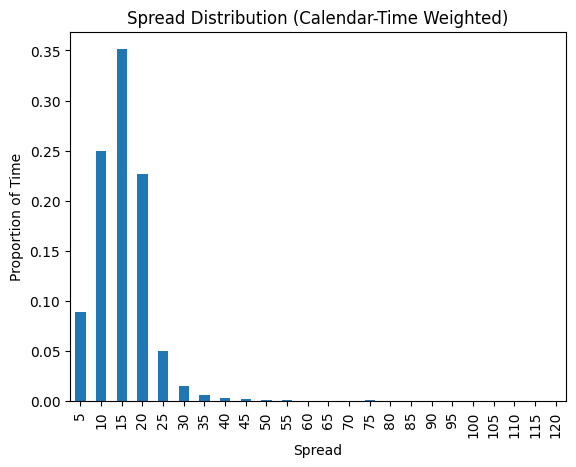

In [22]:
plt.figure()
spread_freq_calendar.plot(kind='bar')
plt.title("Spread Distribution (Calendar-Time Weighted)")
plt.xlabel("Spread")
plt.ylabel("Proportion of Time")
plt.show()

**Interpretation**

Large-tick vs. Small-tick
If most quotes have a spread of exactly 1 tick (and occasionally 2 ticks), that strongly indicates a large-tick stock.
If the spread takes many distinct values (3, 4, 5, … ticks) and moves among them, that’s more typical of a small-tick stock.
Event time vs. Calendar time
In event time, each update/row is counted equally. This distribution can be skewed by brief, rapid quote updates.
In calendar time, a spread that persists for a long period (even if no new events occur) is given a proportionate weight.
In many real-world large-tick stocks, you’ll see the spread pinned at 1 tick for a large fraction of both the events and the time. However, the two distributions can differ because the market might “flicker” among 1–2 ticks frequently in busy periods, but sit quietly at 1 tick for long intervals in slower periods, or vice versa.

Ultimately, comparing these two distributions shows whether the spread changes often but briefly (event time distribution might differ a lot from calendar time), or whether it tends to “stick” at a certain level for long durations (leading to a large chunk of total clock time at that level).

In [23]:
df['mid'] = (df['bp0'] + df['ap0']) / 2
df['IB'] = df['bq0'] / (df['bq0'] + df['aq0'])

In [24]:
df['mid_future'] = df['mid'].shift(-1)  # next event's mid
df['log_ret_next'] = np.log(df['mid_future']) - np.log(df['mid'])

### High Frequency Log-Returns

#### Calendar time

In [25]:
df_trades_min = df.copy()

df_trades_min['ets'] = pd.to_datetime(df_trades_min['ets'])

df_trades_min.set_index('ets', inplace=True)

df_trades_min_resampled = df_trades_min.copy()

df_trades_min_resampled = df_trades_min['eprice'].resample('min').last()

df_trades_min_resampled

ets
2017-01-18 09:01:00    45655
2017-01-18 09:02:00    45620
2017-01-18 09:03:00    46120
2017-01-18 09:04:00    45835
2017-01-18 09:05:00    45660
                       ...  
2017-01-18 17:25:00    47000
2017-01-18 17:26:00    45435
2017-01-18 17:27:00    45410
2017-01-18 17:28:00    45430
2017-01-18 17:29:00    45400
Freq: min, Name: eprice, Length: 509, dtype: int64

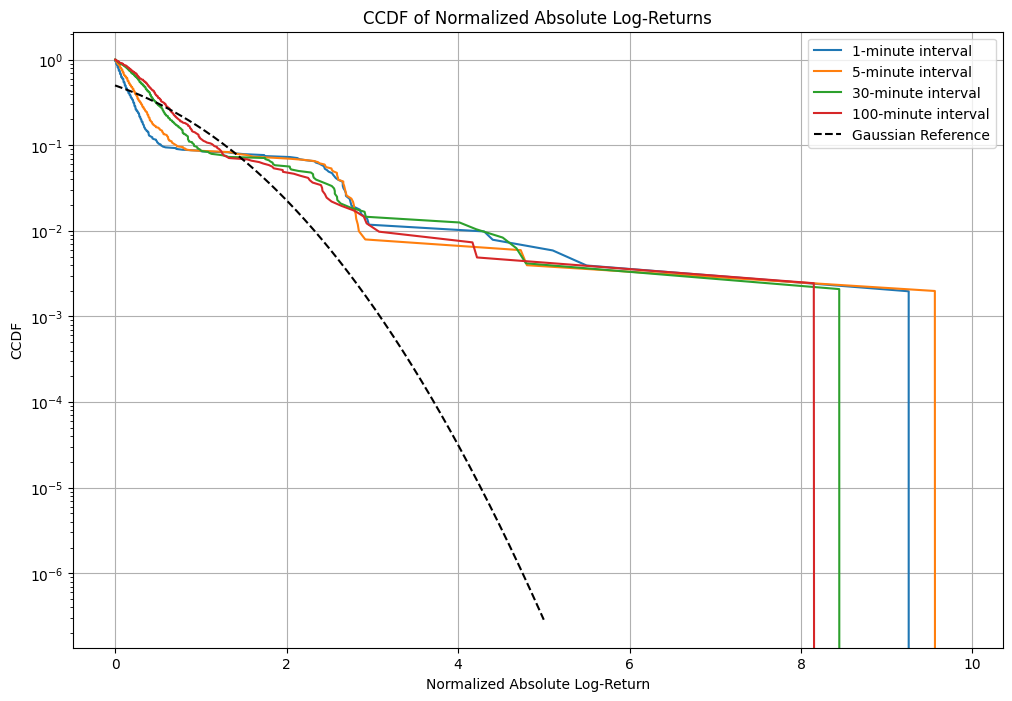

In [26]:
plt.figure(figsize=(12, 8))

frequencies = [1, 5, 30, 100]

for freq in frequencies:
    log_ret = np.log(df_trades_min_resampled / df_trades_min_resampled.shift(freq)).dropna()

    normalized_abs_log_ret = np.abs((log_ret - np.mean(log_ret)) / np.std(log_ret))
    
    sorted_data = np.sort(normalized_abs_log_ret)
    ccdf = 1. - np.arange(1, len(sorted_data)+1) / len(sorted_data)
    
    plt.semilogy(sorted_data, ccdf, label=f'{freq}-minute interval')

gaussian_x = np.linspace(0, 5, 1000)
gaussian_ccdf = 1. - stats.norm.cdf(gaussian_x)
plt.semilogy(gaussian_x, gaussian_ccdf, 'k--', label='Gaussian Reference')

plt.title('CCDF of Normalized Absolute Log-Returns')
plt.xlabel('Normalized Absolute Log-Return')
plt.ylabel('CCDF')
plt.legend()
plt.grid(True)
plt.show()

We see that we are totally out of the gaussian scope and more interestingly : the frequency at which we look at the log-returns matter, the faster the frequency the less gaussian in principle. Here we see that on a specific day : we can find a counter-example : the 5 mins mark return compared to the 1 minute.

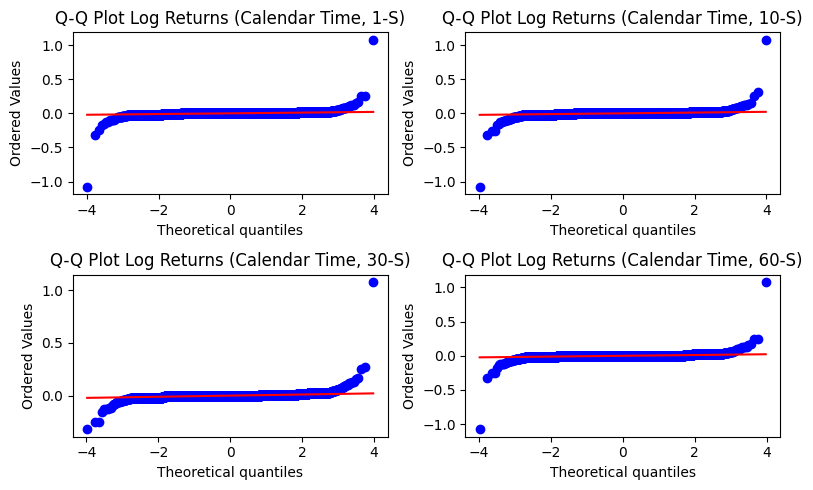

In [27]:
df_trades_seconds = df.copy()
df_trades_seconds['ets'] = pd.to_datetime(df_trades_seconds['ets'])
df_trades_seconds.set_index('ets', inplace=True)
df_trades_seconds_resampled = df_trades_seconds.copy()
df_trades_seconds_resampled = df_trades_seconds['eprice'].resample('1s').last()

freqs = [1, 10, 30, 60]
fig, axes = plt.subplots(2, 2, figsize=(8, 5))

# Generate each Q-Q plot in a separate subplot.
for ax, freq in zip(axes.flatten(), freqs):
    log_ret = np.log(
        df_trades_seconds_resampled / df_trades_seconds_resampled.shift(freq)
        ).dropna()
    
    stats.probplot(log_ret, dist="norm", plot=ax)
    ax.set_title(f'Q-Q Plot Log Returns (Calendar Time, {freq}-S)')

plt.tight_layout()
plt.show()

We can see that the log-returns are not normally distributed. We can see that the data has heavier tails than a normal distribution.

#### Event time

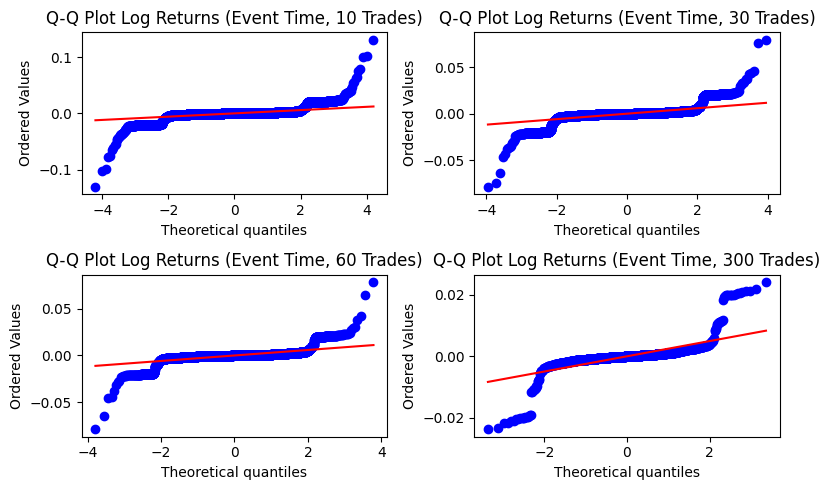

In [28]:
df_trades_event = df.copy()
df_trades_event['ets'] = pd.to_datetime(df_trades_event['ets'])
df_trades_event = df_trades_event.sort_values('ets')  # Ensure chronological order

# Reindex based on trade event count
df_trades_event = df_trades_event.reset_index(drop=True)

# Define event-based sampling frequencies
event_sizes = [10, 30, 60, 300]  # Every 10, 30, 60 or 300 trades

fig, axes = plt.subplots(2, 2, figsize=(8, 5))

for ax, event_size in zip(axes.flatten(), event_sizes):
    df_sampled = df_trades_event.iloc[::event_size]  # Take every N-th trade
    log_ret_event = np.log(df_sampled['eprice'] / df_sampled['eprice'].shift(1)).dropna()

    # Q-Q Plot for normality check
    stats.probplot(log_ret_event, dist="norm", plot=ax)
    ax.set_title(f'Q-Q Plot Log Returns (Event Time, {event_size} Trades)')

plt.tight_layout()
plt.show()


The data in event time has a more pronounced heavy tail than the calendar one. This might mean, that at some time, in calendar time, the prices dont change much, but when they do, they do it in a more pronounced way.

### 5. Volatility in high-frequency

In [29]:
df_trades = df.copy()
df_trades['ets'] = pd.to_datetime(df_trades['ets'])

df_trades.set_index('ets', inplace=True)

df_trades_resampled = df_trades['eprice'].resample('S').last()
df_trades_resampled = df_trades_resampled.fillna(method="ffill")
df_trades_resampled

C:\Users\Marti\AppData\Local\Temp\ipykernel_10932\47223661.py:6: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  df_trades_resampled = df_trades['eprice'].resample('S').last()
C:\Users\Marti\AppData\Local\Temp\ipykernel_10932\47223661.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_trades_resampled = df_trades_resampled.fillna(method="ffill")


ets
2017-01-18 09:01:00    46045.0
2017-01-18 09:01:01    45910.0
2017-01-18 09:01:02    45820.0
2017-01-18 09:01:03    46055.0
2017-01-18 09:01:04    45970.0
                        ...   
2017-01-18 17:29:55    45370.0
2017-01-18 17:29:56    45760.0
2017-01-18 17:29:57    45425.0
2017-01-18 17:29:58    46000.0
2017-01-18 17:29:59    45400.0
Freq: s, Name: eprice, Length: 30540, dtype: float64

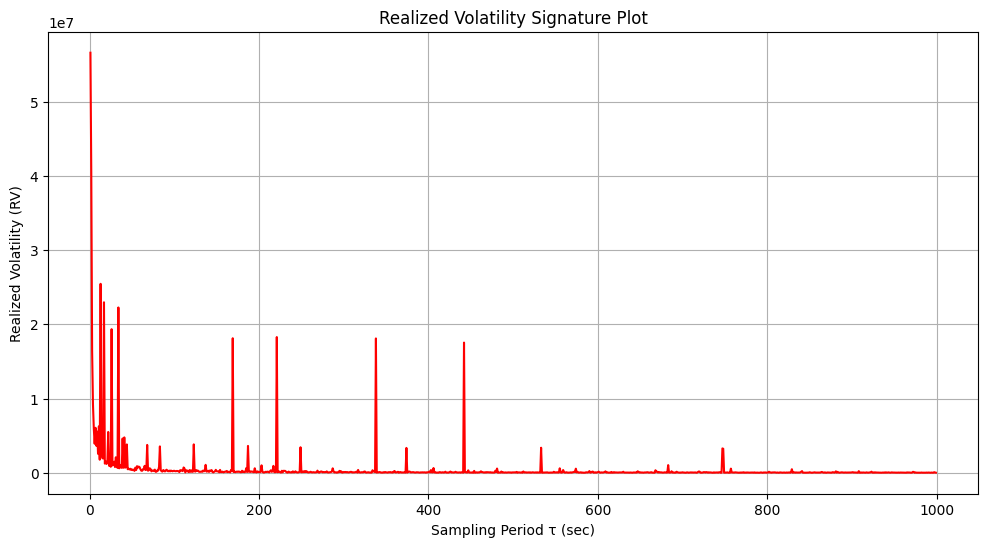

In [30]:
def realized_volatility(prices, tau):
    res = 0
    for i in range(1, int(len(prices)/tau)):
        res += (prices[i*tau] - prices[(i-1)*tau])**2
    return res/100
    

sampling_periods = np.arange(1, 1000, 1)

rv_estimates = [realized_volatility(df_trades_resampled.values, tau) for tau in sampling_periods]

plt.figure(figsize=(12, 6))
plt.plot(sampling_periods, rv_estimates, color='red')
plt.title('Realized Volatility Signature Plot')
plt.xlabel('Sampling Period τ (sec)')
plt.ylabel('Realized Volatility (RV)')
plt.grid(True)
plt.show()

Trade signs

---
Hugo: are we using df correctly? are they truly only the trades?

---

### Imbalance

In [88]:
files = get_all_files(os.path.join('data', 'SG'))

dfs = []

for i, file in enumerate(files):
    df_small = pd.read_csv(os.path.join('data', 'SG', file), index_col = 0)
    dfs.append(df_small)
df = pd.concat(dfs)
df['ets'] = pd.to_datetime(df['ets'], format='%Y%m%d:%H:%M:%S.%f')
df.head()

len(df)

7827010

In [89]:
df_trades = df[df['etype'] == 'T'].copy()

df_trades['mid_price'] = (df_trades['bp0'] + df_trades['ap0']) / 2
df_trades['spread'] = df_trades['ap0'] - df_trades['bp0']


df_trades['imbalance'] = (df_trades['bq0'] - 
                          df_trades['aq0']) / (df_trades['bq0'] + 
                                               df_trades['aq0'])
df_trades

,ets,etype,eprice,eqty,eside,bp0,bq0,ap0,aq0,mid_price,spread,imbalance
34,2017-01-17 09:01:08.420210,T,46080,352,B,46080,90,46085,1445,46082.5,5,-0.882736
35,2017-01-17 09:01:08.420222,T,46080,90,B,46010,1339,46085,1445,46047.5,75,-0.038075
52,2017-01-17 09:01:08.444495,T,46085,484,S,46010,855,46085,731,46047.5,75,0.078184
53,2017-01-17 09:01:08.444769,T,46085,731,S,46010,855,46100,1000,46055.0,90,-0.078167
102,2017-01-17 09:01:08.639756,T,46080,310,B,46080,88,46100,1000,46090.0,20,-0.838235
...,...,...,...,...,...,...,...,...,...,...,...,...
701033,2017-02-01 17:29:54.063929,T,46000,148,B,45995,1352,46010,906,46002.5,15,0.197520
701052,2017-02-01 17:29:54.080847,T,45995,52,B,45995,912,46010,906,46002.5,15,0.003300
701086,2017-02-01 17:29:54.587368,T,45995,30,B,45995,714,46005,202,46000.0,10,0.558952
701091,2017-02-01 17:29:55.021665,T,45995,714,B,45990,410,46005,202,45997.5,15,0.339869


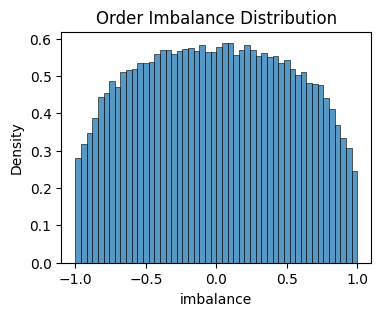

In [94]:
plt.figure(figsize=(4,3))
sns.histplot(df_trades['imbalance'], bins=50, kde=False,
             stat='density')
plt.ylabel('Density')
plt.title('Order Imbalance Distribution')
plt.show()

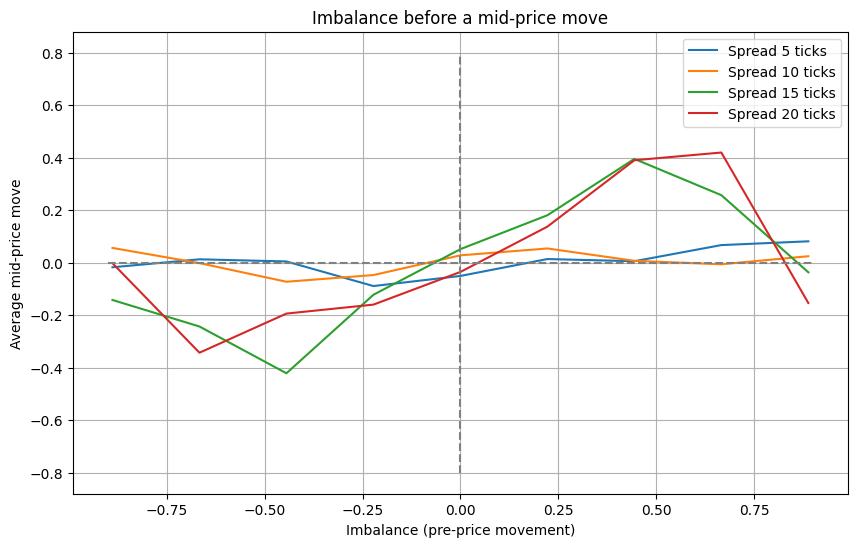

In [ ]:
df_trades['mid_price_move'] = df_trades['mid_price'].diff()

# This defines the edges of the bins
imbalance_bins = np.linspace(-1, 1, 10)
middle_bin_values = (imbalance_bins[1:] + imbalance_bins[:-1]) / 2

df_trades['imbalance_bin'] = pd.cut(df_trades['imbalance'], 
                                    bins=imbalance_bins, labels=False,
                                    include_lowest=True
                                    )

# Compute mean mid-price move for each imbalance bin and spread category
plot_data = df_trades.groupby(['imbalance_bin', 'spread']
                              )['mid_price_move'].mean().reset_index()
plot_data_vol = df_trades.groupby(['imbalance_bin', 'spread']
                                  )['mid_price_move'].var().reset_index()

# Pivot for plotting
pivot_data = plot_data.pivot(index='imbalance_bin', 
                             columns='spread', values='mid_price_move')
pivot_data_vol = plot_data_vol.pivot(index='imbalance_bin', 
                                     columns='spread', values='mid_price_move')

# Plot
plt.figure(figsize=(10, 6))
for spread in [5, 10, 15, 20]:
    plt.plot(middle_bin_values, pivot_data[spread], label=f'Spread {spread}')
    """ plt.fill_between(middle_bin_values, 
                     pivot_data[spread] - pivot_data_vol[spread], 
                     pivot_data[spread] + pivot_data_vol[spread], 
                     alpha=0.2) """
    
plt.vlines(0, linestyles='dashed', colors='gray', ymin=-0.8, ymax=0.8)
plt.hlines(0, linestyles='dashed', colors='gray', xmin=-0.9, xmax=0.9)
plt.xlabel("Imbalance (pre-price movement)")
plt.ylabel("Average mid-price move")
plt.title("Imbalance before a mid-price move")
plt.legend()
plt.grid(True)
plt.show()